In [13]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt

import keras_tuner as kt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from keras.callbacks import EarlyStopping
import shutil

### Montar Dataframe

In [14]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [15]:
# Query para consulta dos dados agrupados por taxa média por quadrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

In [16]:
# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [17]:
# Copiar dataframe para manipular dados
time_series = df.copy()

In [18]:
# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

In [19]:
# # Filtrar dados até final de 2019
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

In [20]:
# Setando o quadrimestre como índice da tabela
time_series = time_series.set_index('quadrimestre')

In [21]:
time_series

,taxa_media_yll
quadrimestre,
2010-04-30,6.427726
2010-08-31,6.767661
2010-12-31,6.111099
2011-04-30,6.550037
2011-08-31,6.878076
2011-12-31,5.804813
2012-04-30,6.280719
2012-08-31,6.739170
2012-12-31,6.049970


### Modelo LSTM

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step - loss: 0.2627 - mean_squared_error: 0.2627 - val_loss: 0.3733 - val_mean_squared_error: 0.3733
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2446 - mean_squared_error: 0.2446 - val_loss: 0.3187 - val_mean_squared_error: 0.3187
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1939 - mean_squared_error: 0.1939 - val_loss: 0.2250 - val_mean_squared_error: 0.2250
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1048 - mean_squared_error: 0.1048 - val_loss: 0.0978 - val_mean_squared_error: 0.0978
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0754 - val_mean_squared_error: 0.0754
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0757 - val_mean_squared_error: 0.0757
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0651 - mean_squared_error: 0.0651 - val_loss: 0.1000 - v

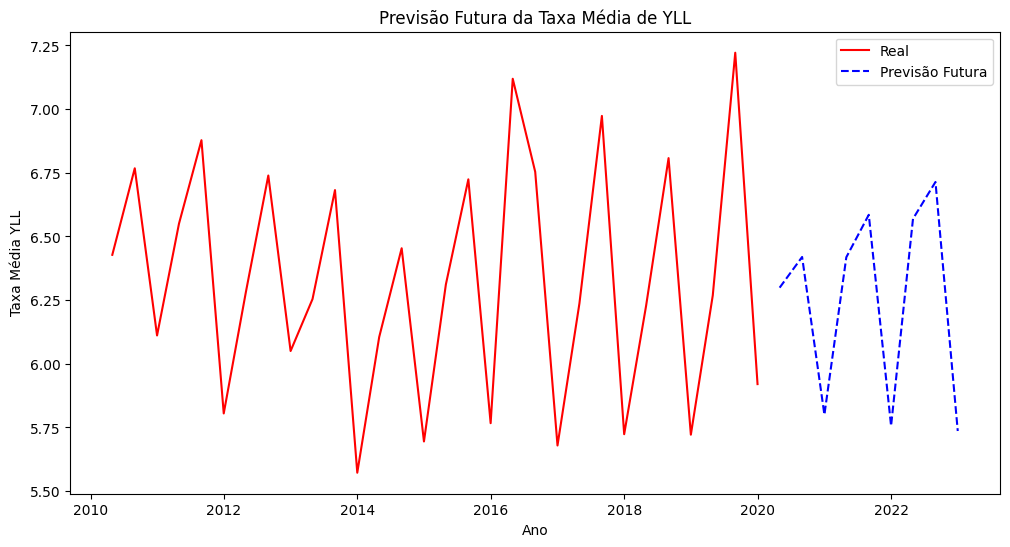

In [22]:
# Normaliza os Dados
normalizer = MinMaxScaler(feature_range=(0, 1))
train_data = normalizer.fit_transform(time_series.values)

# Cria os Arrays No Formato Certo
window_size = 3
x = []
y = []
for i in range(window_size, len(train_data)):
    x.append(train_data[i - window_size:i, 0])
    y.append(train_data[i, 0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

# Treina com todos os dados
def build_model_for_future(hp=None):
    regressor = Sequential()
    regressor.add(LSTM(units=800, return_sequences=True, input_shape=(x.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=300, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=100, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=200))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1, activation='linear'))
    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return regressor

# Inicializa o modelo
model = build_model_for_future()

# Callback para Early Stopping
early_stopping = EarlyStopping(
    monitor='loss',
    patience=100,
    restore_best_weights=True
)

# Treina o modelo com todos os dados disponíveis
history = model.fit(
    x, y,
    batch_size=16,
    epochs=1000,
    callbacks=[early_stopping],
    validation_split=0.1
)

# Previsão Futura
future_steps = 9
last_window = train_data[-window_size:]
predictions = []

for _ in range(future_steps):
    last_window_reshaped = np.reshape(last_window, (1, last_window.shape[0], 1))
    prediction = model.predict(last_window_reshaped)
    predictions.append(prediction[0, 0])
    last_window = np.append(last_window[1:], prediction, axis=0)

# Revertendo a Normalização
future_predictions = normalizer.inverse_transform(np.array(predictions).reshape(-1, 1))

# Gerando Datas para os Próximos 9 Quadrimestres
last_date = time_series.index[-1]
future_dates = [last_date + pd.DateOffset(months=4 * i) for i in range(1, future_steps + 1)]

# Criação do DataFrame com as Previsões Futuras
future_results = pd.DataFrame({
    'Data': future_dates,
    'Previsao YLL': future_predictions.flatten()
})
future_results.set_index('Data', inplace=True)

# Exibindo as Previsões Futuras
print(future_results)

# Plotando as Previsões Futuras
plt.figure(figsize=(12, 6))
# plt.plot(time_series.index, time_series.values, color='red', label='Real')
plt.plot(time_series.index, time_series.values, color='red', label='Real')
plt.plot(future_results.index, future_results['Previsao YLL'], color='blue', label='Previsão Futura', linestyle='dashed')
plt.title('Previsão Futura da Taxa Média de YLL')
plt.ylabel('Taxa Média YLL')
plt.xlabel('Ano')
plt.legend()
plt.show()


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.2814
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2605
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1991
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1095
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0781
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1107
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0659
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0719
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0764
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0795
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0725
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0602
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0554
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0680
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0649
Epoch 16/100
2/2 ━━

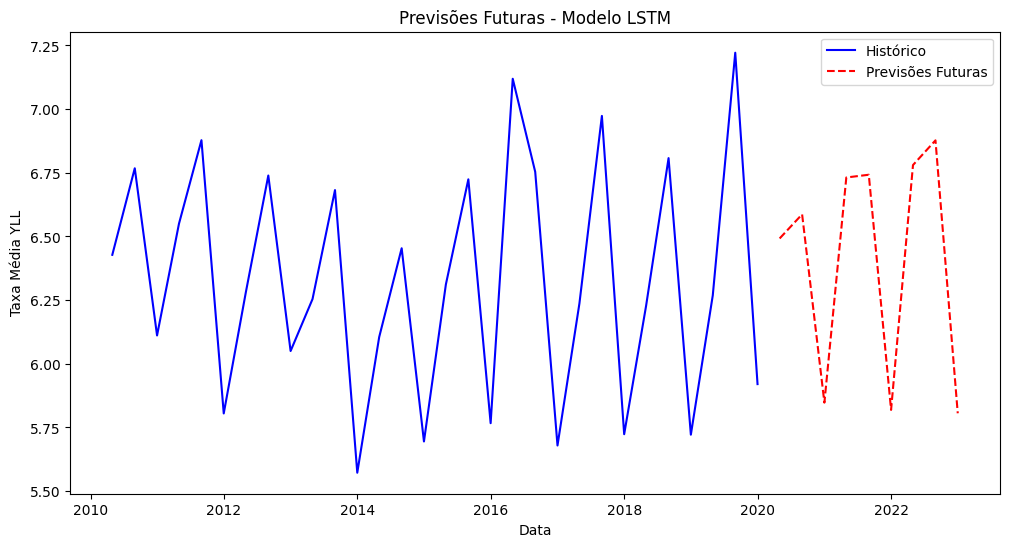

            Previsão
2020-04-30  6.491989
2020-08-31  6.586791
2020-12-31  5.847256
2021-04-30  6.731489
2021-08-31  6.742247
2021-12-31  5.818650
2022-04-30  6.780334
2022-08-31  6.877328
2022-12-31  5.805460


In [23]:
# Normalizando os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series.values)

# Criando janelas deslizantes
window_size = 3
x = []
y = []
for i in range(window_size, len(scaled_data)):
    x.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

# 2. Treinando o modelo com todos os dados históricos
model = Sequential()
model.add(LSTM(units=800, return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=300, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=200))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
model.fit(x, y, epochs=100, batch_size=16, verbose=1)

# 3. Fazendo previsões futuras
# Criando um array para armazenar os períodos futuros
future_steps = 9  # Número de períodos futuros a prever
last_window = scaled_data[-window_size:]  # Última janela usada para previsões futuras
future_predictions = []

for _ in range(future_steps):
    prediction = model.predict(last_window[np.newaxis, :, :])
    future_predictions.append(prediction[0, 0])
    last_window = np.append(last_window[1:], prediction, axis=0)

# Revertendo a normalização
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Criando um dataframe para as previsões futuras
last_date = time_series.index[-1]
future_dates = [last_date + pd.DateOffset(months=4 * i) for i in range(1, future_steps + 1)]
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Previsão'])

# 4. Plotando as previsões
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Histórico', color='blue')
plt.plot(future_df, label='Previsões Futuras', color='red', linestyle='dashed')
plt.title('Previsões Futuras - Modelo LSTM')
plt.xlabel('Data')
plt.ylabel('Taxa Média YLL')
plt.legend()
plt.show()

# Mostrando os resultados
print(future_df)
